<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/SHARPE_SORT%C4%B0NO_CALMAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-1-9a60d5d27120>:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df = stocks.pct_change().dropna()


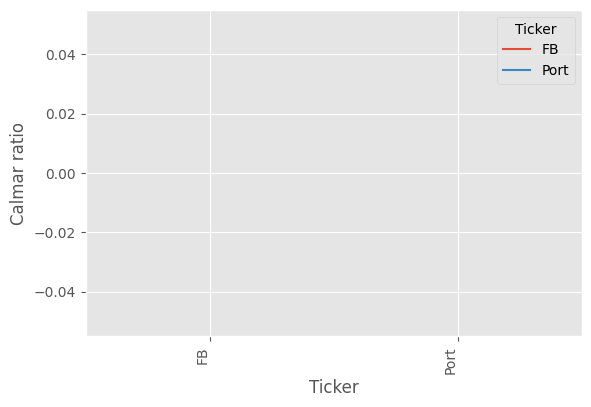

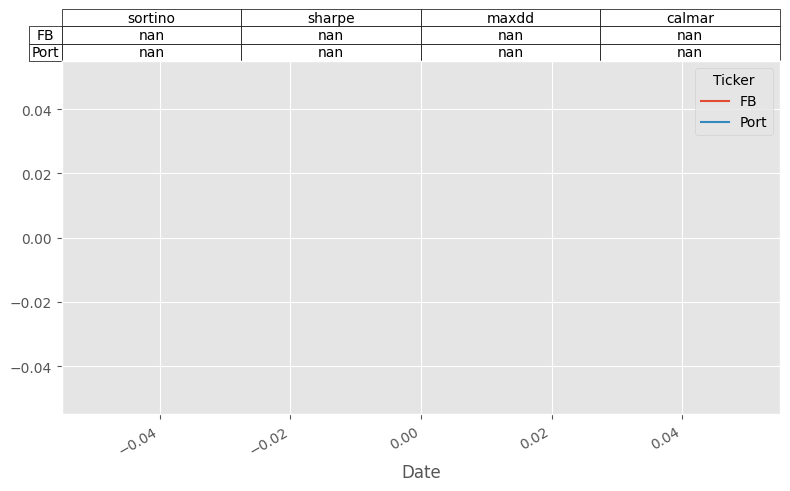

In [1]:
import yfinance as yf
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

start = dt.datetime(2013, 1, 1)
end = dt.datetime(2020, 10, 1)

tickers = ['AAPL', 'AMZN', 'MSFT', 'GOOGL', 'FB']

stocks = yf.download(tickers, start=start, end=end)['Adj Close']

stocks.head()

df = stocks.pct_change().dropna()
df['Port'] = df.mean(axis=1)  # 20% apple, ..., 20% facebook
(df + 1).cumprod().plot()

(df + 1).cumprod()[-1:]

def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N - rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255  # 255 trading days in a year
rf = 0.01  # 1% risk-free rate
sharpes = df.apply(sharpe_ratio, args=(N, rf,), axis=0)

sharpes.plot.bar()

def sortino_ratio(series, N, rf):
    mean = series.mean() * N - rf
    std_neg = series[series < 0].std() * np.sqrt(N)
    return mean / std_neg

sortinos = df.apply(sortino_ratio, args=(N, rf,), axis=0)
sortinos.plot.bar()
plt.ylabel('Sortino Ratio')

def max_drawdown(return_series):
    comp_ret = (return_series + 1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret / peak) - 1
    return dd.min()

max_drawdowns = df.apply(max_drawdown, axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')

calmars = df.mean() * 255 / abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')

btstats = pd.DataFrame()
btstats['sortino'] = sortinos
btstats['sharpe'] = sharpes
btstats['maxdd'] = max_drawdowns
btstats['calmar'] = calmars

btstats

(df + 1).cumprod().plot(figsize=(8, 5))
plt.table(cellText=np.round(btstats.values, 2), colLabels=btstats.columns,
          rowLabels=btstats.index, rowLoc='center', cellLoc='center', loc='top',
          colWidths=[0.25] * len(btstats.columns))
plt.tight_layout()
